# Example tracking workflow
## Comments
- Mention that throughout:
    - "coords" will be the full table of coordinates, along with assigned track IDs
    - "tracks" will be the coordinates of the most recent track instance
    - "points" will be the coordinates for the current frame

## Ideas
- Cover both Munkres (dense cost matrix) and JV LAPMOD (sparse cost matrix) for linking, comparing speed and memory allocation for different number of points.  This may be one for the talk, rather than having others do it.  That way it doesn't matter what memory is available.
- Start by getting a basic (adjacent frames only, no track splitting/merging) workflow completed.  For the previous frames, set start_frame and end_frame to the same value (i.e. frame-1).
- Add more factors to cost matrix.  The easiest to show may be conservation of size.  Mention that we could also add a threshold for size change, but we won't.  Example data will need to have instances of miss-linking that are resolved with size-based linking.
- Add multi-frame tracking by extending linking to n previous frames.  This will require addition of extraction of only the most recent instances of each track.
- Switch to using a Kalman filter to predict the location of each active track in the current frame, then calculate costs based on the distance of each point to this predicted location.  When describing the Kalman Filter, maybe use the pair of images from the section "THE KALMAN GAIN INTUITION" on the page https://www.kalmanfilter.net/kalman1d.html.


## Installing packages

In [3]:
!pip install --user matplotlib
!pip install --user pandas
!pip install --user Pillow
!pip install --user scikit-image
!pip install --user opencv-python

## Importing libraries

In [1]:
import math
import sys
import time
import util

import numpy as np

from scipy.optimize import linear_sum_assignment

## Getting coordinates present in frame

In [2]:
def get_current_coords(coords, frame):
    # Identifying rows of "coords" with current frame number
    rows = coords.index[coords.FRAME == frame]

    return rows

## Get available tracks

In [3]:
def get_available_tracks(coords, start_frame, end_frame):
    # Getting all rows present within the specified time interval
    rows = coords.index[(coords.FRAME >= start_frame) & (coords.FRAME <= end_frame)]
    
    # Getting the most recent instance of this track
    track_rows = []
    unique_IDs = np.unique(coords.TRACK_ID[rows])
    for unique_ID in unique_IDs:
        if unique_ID != 0:
            # Getting rows for all instances of this track
            instances = coords.index[coords.TRACK_ID == unique_ID]    
            
            # Getting most recent instance of this track and appending it to final_rows
            track_rows.append(instances[-1:][0])
                    
    return track_rows

## Assigning track IDs to unlinked points

In [4]:
def assign_new_IDs(coords, point_rows):
    # Getting the maximum track ID present in coords
    max_ID = coords.TRACK_ID.max()
    
    # Iterating over all current points and assigning the next available ID if they're still 0
    for point_row in point_rows:
        if coords.TRACK_ID[point_row] == 0:
            max_ID = max_ID + 1
            coords.TRACK_ID.at[point_row] = max_ID

## Predict track location

In [5]:
def get_predicted_location(coords, track_ID):
    # Extract the x,y,t coordinates for the current track
    
    # Use the Kalman filter to predict the location of this track
    
    return 0

## Calculate linking costs

In [6]:
def calculate_dense_cost_matrix(coords,track_rows,point_rows,thresh):
    # Creating the empty array
    costs = np.empty((len(track_rows),len(point_rows)))
        
    # Iterating over each pair, calculating the cost
    for track_i, track_row in enumerate(track_rows):
        for point_i,point_row in enumerate(point_rows):            
            cost = calculate_cost(coords,track_row,point_row,thresh)
            costs[track_i,point_i] = cost
           
    return costs
    
def calculate_cost(coords,track_row,point_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords.X[point_row] - coords.X[track_row]
    dy = coords.Y[point_row] - coords.Y[track_row]
    d = math.sqrt(dx*dx + dy*dy)
    
    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = 1000000000
    
    return d

def calculate_cost_with_size(coords,track_row,point_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords.X[point_row] - coords.X[track_row]
    dy = coords.Y[point_row] - coords.Y[track_row]
    d = math.sqrt(dx*dx + dy*dy)
    
    # ADD SIZE COST
    
    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = 1000000000
    
    return d

## Inheriting track IDs from previous frame
If the linked point in the previous frame already has an ID assigned to it, pass this on to the linked point (this SHOULD always be the case).  If our point wasn't assigned a link, set its track ID to the smallest unused value.

In [7]:
def assign_IDs(costs, assignments, coords, track_rows, point_rows):
    for track_assignment, point_assignment in zip(assignments[0],assignments[1]):
        # Even though we set disallowed costs to 1000000000, if there are no better options, Munkres will still assign these. 
        # We need to check if the assignment corresponds to one of these disallowed assignments.
        if costs[track_assignment,point_assignment] < 1000000000:
            ID = coords.TRACK_ID[track_rows[track_assignment]]
            coords.TRACK_ID.at[point_rows[point_assignment]] = ID


## Calculating track statistics
This should eventually return an array with each statistic listed for each track
- Total path length
- Euclidean distance
- Directionality
- Mean track speed
- MSD
- Angular statistics
    - Average direction

In [41]:
def calculate_track_statistics(coords):
    # Getting unique track IDs
    unique_IDs = np.unique(coords.TRACK_ID)
    
    for unique_ID in unique_IDs:
        print("TRACK",unique_ID)
        # Getting row indices for this track
        track_rows = coords.index[coords.TRACK_ID == unique_ID]
        
        total_path_length = calculate_total_path_length(coords,track_rows)
        path_euclidean_distance = calculate_path_euclidean_distance(coords,track_rows)
        directionality_ratio = calculate_directionality_ratio(total_path_length,path_euclidean_distance)
        mean_track_orientation = calculate_mean_track_orientation(coords,track_rows)
    
        print("    Total path length =",total_path_length,"px")
        print("    Path Euclidean distance =",path_euclidean_distance,"px")
        print("    Path directionality ratio =",directionality_ratio)
        print("    Mean track orientation =",mean_track_orientation," degs")
    
        
def calculate_total_path_length(coords,track_rows):
    path_length = 0
    
    for i in range(1,len(track_rows)):
        x1 = coords.X[i-1]
        x2 = coords.X[i]
        y1 = coords.Y[i-1]
        y2 = coords.Y[i]
        
        dx = x2-x1
        dy = y2-y1
        
        distance = math.sqrt(dx*dx+dy*dy)
        
        path_length = path_length + distance
    
    return path_length

def calculate_path_euclidean_distance(coords,track_rows):
    # Getting coordinates for first and last points
    x1 = coords.X[track_rows[0]]
    x2 = coords.X[track_rows[-1]]
    y1 = coords.Y[track_rows[0]]
    y2 = coords.Y[track_rows[-1]]
    
    dx = x2-x1
    dy = y2-y1
        
    # Returning the end-to-end distance
    return math.sqrt(dx*dx+dy*dy)

def calculate_directionality_ratio(total_path_length,euclidean_distance):
    # If the total path length is 0 we will get a divide by 0 error.  As such, we return a NaN (not a number) value
    if total_path_length == 0:
        return np.nan
    
    return euclidean_distance/total_path_length

def calculate_mean_track_orientation(coords,track_rows):
    # Getting total x and y vector magnitudes
    x_sum = 0
    y_sum = 0
    
    for i in range(1,len(track_rows)):
        x1 = coords.X[i-1]
        x2 = coords.X[i]
        y1 = coords.Y[i-1]
        y2 = coords.Y[i]
        
        x_sum = x_sum + (x2-x1)
        y_sum = y_sum + (y2-y1)
    
    # Calculating the average x and y vectors
    n = len(track_rows)
    x_vec = x_sum/n
    y_vec = y_sum/n
    
    # Returning the orientation of these final vectors
    return math.degrees(math.atan(y_vec/x_vec))
    

## Main workflow

In [42]:
# Testing track measurements
path = "../data/TrackedCoordinatesNoHeader.csv"
coords = util.load_coordinates(path);

calculate_track_statistics(coords)


Loading coordinates from " ../data/TrackedCoordinatesNoHeader.csv "
Loaded data shape:  (8639, 5)
 
TRACK 1.0
    Total path length = 7296.385049661778 px
    Path Euclidean distance = 8.758488454793966 px
    Path directionality ratio = 0.0012003873692493742
    Mean track orientation = -11.076549734168308  degs
TRACK 8.0
    Total path length = 14571.542978599602 px
    Path Euclidean distance = 33.015148038438355 px
    Path directionality ratio = 0.0022657276643198204
    Mean track orientation = -6.397354127522787  degs
TRACK 9.0
    Total path length = 14571.542978599602 px
    Path Euclidean distance = 78.45514249524551 px
    Path directionality ratio = 0.005384134172370636
    Mean track orientation = -6.397354127522787  degs
TRACK 10.0
    Total path length = 276.7852950281905 px
    Path Euclidean distance = 13.636972920295404 px
    Path directionality ratio = 0.04926913808375002
    Mean track orientation = 14.931417178137552  degs
TRACK 12.0
    Total path length = 8772.5

ZeroDivisionError: float division by zero

In [26]:
%matplotlib notebook

# Setting parameters
np.set_printoptions(precision=3,threshold=sys.maxsize)
linking_thresh = 10
frame_thresh = 2

# # Loading image stack
path = "..\\data\\ExampleTimeseries.tif"
images = util.load_images(path);

# Loading coordinates
path = "../data/ObjectCoordinatesNoHeader.csv"
coords = util.load_coordinates(path);

# Getting the number of frames
n_frames = images.shape[2]

# Set new track IDs for each object in the first frame
point_rows = get_current_coords(coords,0)
assign_new_IDs(coords,point_rows)

# Starting at frame 2, looping over each frame, linking pairs
for frame in range(1,20):#range (1,n_frames):    
    sys.stdout.write("\rProcessing frame %i" % frame)
    
    start_frame = frame-1-frame_thresh
    end_frame = frame-1
    
    # Get row labels for the previous and current frame
    track_rows = get_available_tracks(coords,start_frame,end_frame)
    point_rows = get_current_coords(coords,frame)
    
    # Calculate costs for each possible link, then use Munkres to determine assignments
    costs = calculate_dense_cost_matrix(coords,track_rows,point_rows,linking_thresh)    
    assignments = linear_sum_assignment(costs)
        
    # Assigning links
    assign_IDs(costs,assignments,coords,track_rows,point_rows)
    assign_new_IDs(coords,point_rows)
    
print("")
print("Complete!")

Loading images from " ..\data\ExampleTimeseries.tif "
Loaded image shape:  (92, 700, 1100)
Reordered image shape:  (700, 1100, 92)
 
Loading coordinates from " ../data/ObjectCoordinatesNoHeader.csv "
Loaded data shape:  (8639, 6)
 
Processing frame 19
Complete!


In [11]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

Rendering frame 92 of 92

<IPython.core.display.Javascript object>


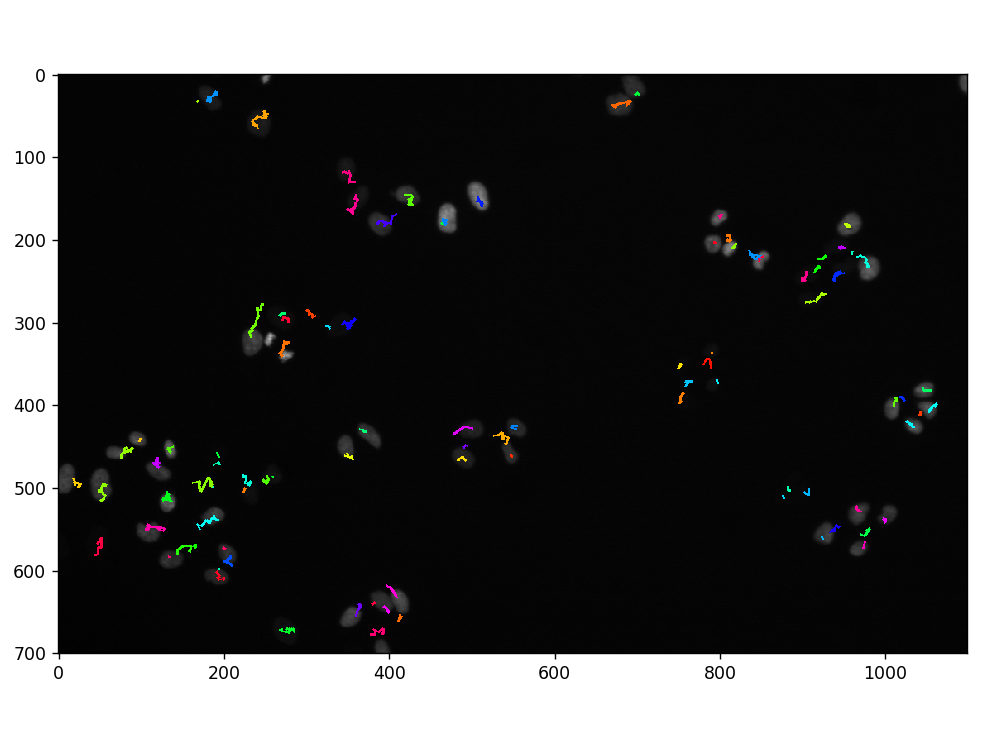

interactive(children=(IntSlider(value=0, description='frame', max=91), Output()), _dom_classes=('widget-intera…

In [12]:
# Adding track renders
util.show_overlay(images,coords)